In [ ]:
import pyodbc
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


# Connexion SQL Server
server = 'DESKTOP-OQ959SK'
database = 'FinalDW'
conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

try:
    conn = pyodbc.connect(conn_str)
    print("✅ Connexion réussie !")
except Exception as e:
    print("❌ Échec de connexion :", e)

# Requête SQL
query = """
SELECT 
    dp.ProductID,
    dp.ProductName,
    dc.Category AS Category_Name,
    db.brandname AS Brand_Name,
    COUNT(DISTINCT dm.Material_ID) AS Nb_Ingredients,
    AVG(fd.Dosage) AS Dosage_Moyen,
    dd_m.Year AS Manufacture_Year,
    dd_m.Month AS Manufacture_Month,
    dd_e.Year AS Expiry_Year,
    dd_e.Month AS Expiry_Month,
    DATEDIFF(DAY, dd_m.Full_Date, dd_e.Full_Date) AS Duree_Validite_Jours

FROM Fact_Production fp
JOIN Dim_Product dp ON fp.Product_PK = dp.Product_PK
JOIN Dim_Category dc ON dp.Category_FK = dc.Category_PK
JOIN Dim_Brand db ON dp.Brand_FK = db.Brand_PK
JOIN Fact_Dosage fd ON fd.Prod_FK = dp.Product_PK
JOIN Dim_Material dm ON fd.Material_FK = dm.Material_PK
JOIN Dim_Date dd_m ON fp.ManufactureDate_PK = dd_m.Date_PK
JOIN Dim_Date dd_e ON fp.ExpiryDate_PK = dd_e.Date_PK

GROUP BY 
    dp.ProductID,
    dp.ProductName,
    dc.Category,
    db.brandname,
    dd_m.Year, dd_m.Month,
    dd_e.Year, dd_e.Month,
    dd_m.Full_Date,
    dd_e.Full_Date
"""

# Lire les résultats dans un DataFrame
df = pd.read_sql(query, conn)
df.head()
print(df)

✅ Connexion réussie !


C:\Users\karim\AppData\Local\Temp\ipykernel_61732\102628007.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   ProductID   ProductName Category_Name                 Brand_Name  \
0     PR-001  Hair Serum 1      Haircare               walker group   
1     PR-002   Body Wash 2      Bodycare      lyons zuniga and wolf   
2     PR-006   Face Wash 6      Skincare  brown townsend and dalton   
3     PR-007       Blush 7        Makeup    gibbs medina and carter   
4     PR-010    Mascara 10        Makeup   jacobs obrien and davila   
..       ...           ...           ...                        ...   
76    PR-875     Blush 538        Makeup   hansen hopkins and smith   
77    PR-883  Lipstick 542        Makeup             lewis and sons   
78    PR-917   Mascara 559        Makeup      lyons zuniga and wolf   
79    PR-919     Blush 560        Makeup   hansen hopkins and smith   
80    PR-993     Blush 597        Makeup               walker group   

    Nb_Ingredients  Dosage_Moyen Manufacture_Year Manufacture_Month  \
0                2             8             2024                08   
1    


🔹 Linear Regression
MAE : 86.93
RMSE : 96.45
R² : 0.56

🔹 Random Forest
MAE : 85.18
RMSE : 105.48
R² : 0.48

✅ Meilleur modèle : Linear Regression avec R² = 0.56
📦 Modèle sauvegardé sous 'modele_expiration.pkl'


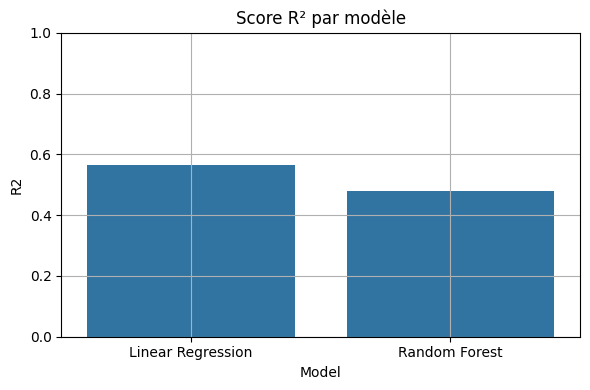

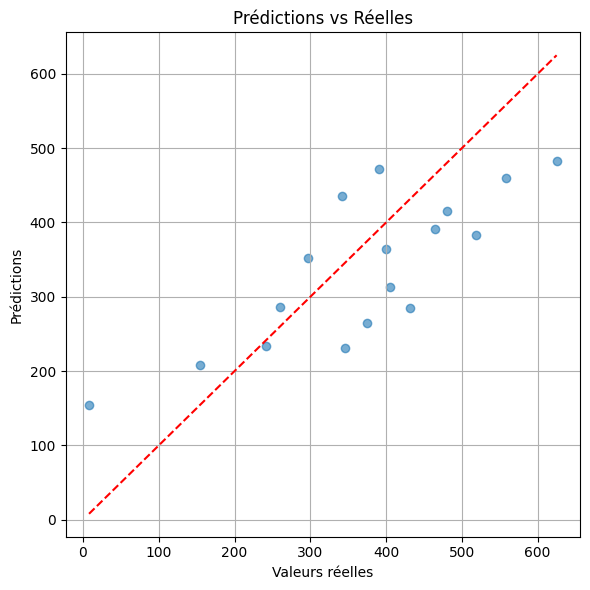

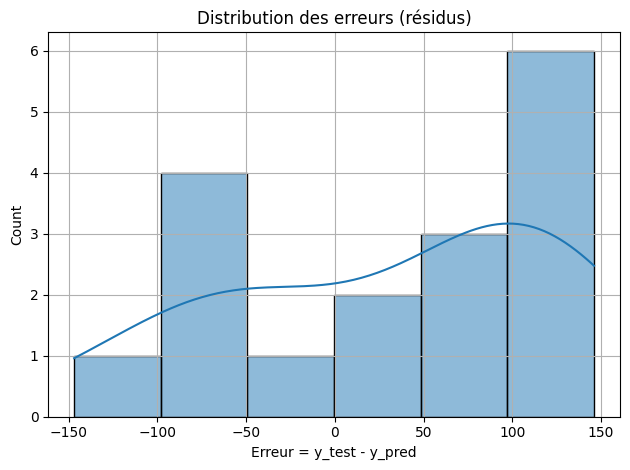

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Ajouter la colonne Season
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df['Season'] = df['Manufacture_Month'].apply(get_season)

# 2. Définir les variables
categorical_features = ['ProductName', 'Category_Name', 'Brand_Name', 'Season']
numerical_features = ['Nb_Ingredients', 'Dosage_Moyen', 'Manufacture_Year', 'Manufacture_Month']
X = df[categorical_features + numerical_features]
y = df['Duree_Validite_Jours']

# 3. Preprocessing
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Modèles à tester
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
}

best_score = -np.inf
best_model_name = None
best_pipeline = None
results = []

# 6. Entraînement et évaluation
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n🔹 {name}")
    print("MAE :", round(mae, 2))
    print("RMSE :", round(rmse, 2))
    print("R² :", round(r2, 2))

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_pipeline = pipeline

print(f"\n✅ Meilleur modèle : {best_model_name} avec R² = {round(best_score, 2)}")

# 7. Sauvegarde du modèle
joblib.dump(best_pipeline, 'modele_expiration.pkl')
print("📦 Modèle sauvegardé sous 'modele_expiration.pkl'")

# 8. 📊 Visualisation

results_df = pd.DataFrame(results)

# 8.1 R² comparatif
plt.figure(figsize=(6, 4))
sns.barplot(data=results_df, x='Model', y='R2')
plt.title("Score R² par modèle")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.2 Prédictions vs Réel
y_pred = best_pipeline.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Réelles")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.3 Distribution des résidus
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution des erreurs (résidus)")
plt.xlabel("Erreur = y_test - y_pred")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.4 Importance des features (si applicable)
model = best_pipeline.named_steps['model']
if hasattr(model, 'feature_importances_'):
    features = best_pipeline.named_steps['preprocessing'].get_feature_names_out()
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_df = feat_df.sort_values(by="Importance", ascending=False).head(10)

    plt.figure(figsize=(6, 4))
    sns.barplot(data=feat_df, y='Feature', x='Importance')
    plt.title("Top 10 Features Importantes")
    plt.tight_layout()
    plt.show()


C:\Users\karim\AppData\Local\Temp\ipykernel_61732\3084183627.py:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\karim\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


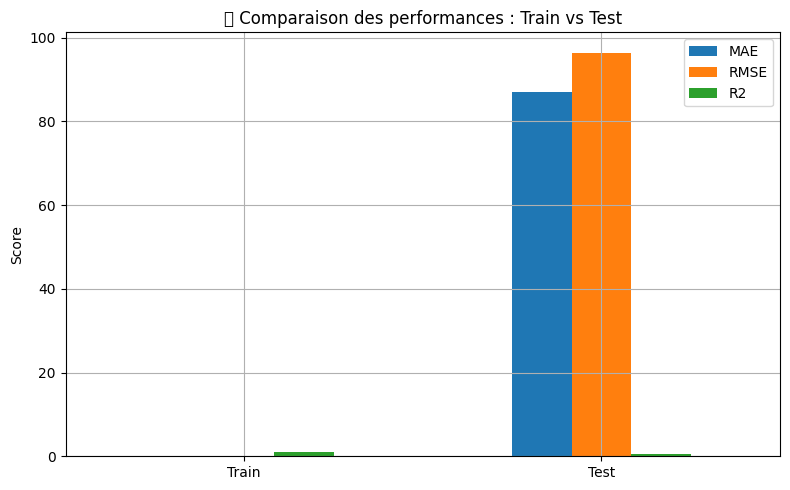

In [ ]:
# 📈 Comparaison train vs test : MAE / RMSE / R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_pred = best_pipeline.predict(X_train)
y_test_pred = best_pipeline.predict(X_test)

train_metrics = {
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R2': r2_score(y_train, y_train_pred)
}

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2': r2_score(y_test, y_test_pred)
}

# Convertir en DataFrame pour visualisation
metrics_df = pd.DataFrame([train_metrics, test_metrics], index=['Train', 'Test'])

# 📊 Affichage
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title("📊 Comparaison des performances : Train vs Test")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


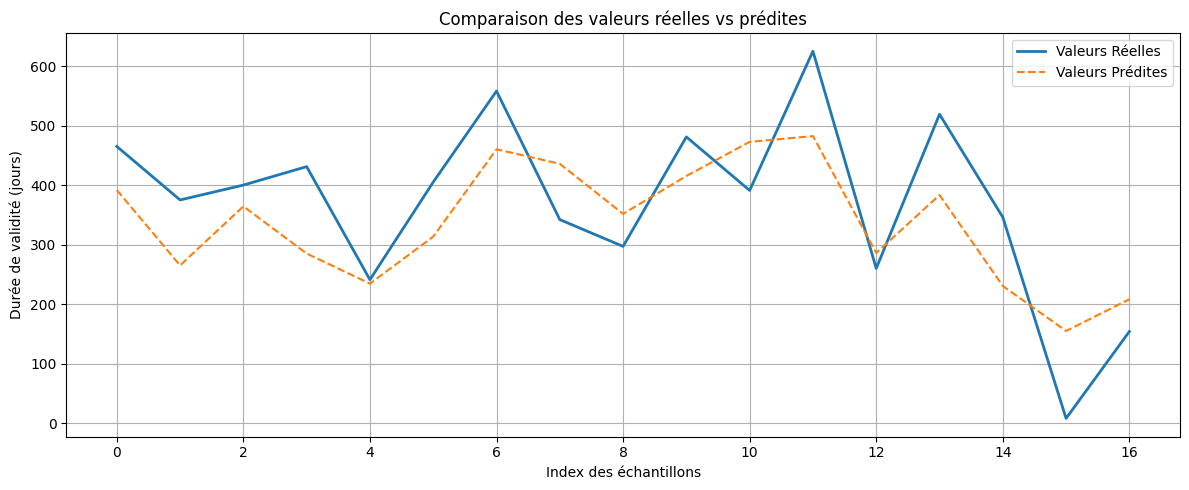

In [11]:
# 🔁 Recalcul des prédictions sur le test set
y_pred = best_pipeline.predict(X_test)

# 🔢 Réindexer pour éviter les mélanges
comparison_df = pd.DataFrame({
    'Réel': y_test.values,
    'Prédit': y_pred
}).reset_index(drop=True)

# 📈 Visualisation en courbe
plt.figure(figsize=(12, 5))
plt.plot(comparison_df['Réel'], label='Valeurs Réelles', linewidth=2)
plt.plot(comparison_df['Prédit'], label='Valeurs Prédites', linestyle='--')
plt.title("Comparaison des valeurs réelles vs prédites")
plt.xlabel("Index des échantillons")
plt.ylabel("Durée de validité (jours)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
